# Project

In [1]:
# imports
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
import pandas as pd
import re
import os.path
import math

from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import csr_matrix, save_npz, load_npz

import wikipedia
import string

import gensim
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.parsing.preprocessing import remove_stopwords


## Data Loading
In the following, we will load the data of our network and process it in order to obtain an adjacency matrix containing only the largest component.

In [2]:
DATA_FOLDER = 'data/'
RES_FOLDER = 'res/'

In [3]:
# Load the necessary dataframes
sites = pd.read_csv(DATA_FOLDER+'articles.tsv', sep='\t', 
                    encoding='UTF-8',engine='python', comment='#', header=None)
sites.columns = ['Site_Name']
sites['Node_ix'] = range(len(sites))
sites = sites.set_index('Site_Name')

links = pd.read_csv(DATA_FOLDER+'links.tsv', sep='\t', encoding='UTF-8',
                    engine='python', comment='#', header=None)
links.columns = ['Start_Site', 'End_Site']

In [4]:
sites.head()

,Node_ix
Site_Name,
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,0
%C3%85land,1
%C3%89douard_Manet,2
%C3%89ire,3
%C3%93engus_I_of_the_Picts,4


In [5]:
# Join edges with sites, in order to have the site index for every site
edges = links.join(sites, on='Start_Site')
edges.columns= ['Start_Site', 'End_Site', 'Start_ix']
edges = edges.join(sites, on='End_Site')
edges.columns= ['Start_Site', 'End_Site', 'Start_ix', 'End_ix']

In [6]:
# Create adjacency matrix
full_adjacency = np.zeros((len(sites),len(sites)),dtype=int)
for idx, row in edges.iterrows():
    i,j = row.Start_ix, row.End_ix
    full_adjacency[i, j]=1

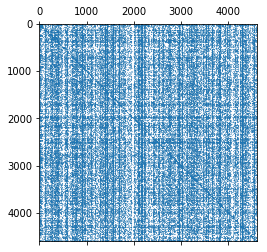

In [7]:
plt.spy(full_adjacency, markersize=.1)
plt.show()

#### Extract Largest Components
In order to have a connected network, we will only work with the largest connected component, which we extract below. In the following, all work will be conducted only on the largest connected component.

In [8]:
from queue import Queue

def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    
    # Your code here.
    # Initialization
    n_nodes = adjacency.shape[0]
    reached = np.zeros(n_nodes) != 0
    components = list()
    
    
    # Iterate as long as there are unreached nodes
    while not(all(reached)):
        # Create FIFO queue with reachable nodes
        q = Queue()
        
        # Create empty list to contain indices of current component
        ix_list = list()
        
        # Put first unreached node in queue
        first_unreached = np.argwhere(reached != True)[0,0]
        q.put(first_unreached)
        reached[first_unreached] = True
    
        # Iterate as long as there are reachable nodes
        while not(q.empty()):
            curr = q.get()
            ix_list.append(curr)
        
            connected = adjacency[:, curr] != 0
        
            # Indices of all adjacent vectors not reached yet
            nex = np.argwhere(np.logical_and(connected, reached != True))[:,0]
        
            for i in nex:
                q.put(i)
                reached[i] = True
                
        # Convert ix_list to array, append to components
        components.append(np.asarray(ix_list))
    
    return components

In [9]:
# Find connected components
components = find_components(full_adjacency)
print("Amount of connected components: " + str(len(components)))

# Find size of every component
comp_size = np.zeros(len(components))
for i in range(len(components)):
    comp_size[i] = components[i].shape[0]
print("Maximal component size: " + str(comp_size.max()))

# Extract Largest Connected Component
largest_component_ix = components[comp_size.argmax()]
no_lc_adjacency = full_adjacency[largest_component_ix, :][:, largest_component_ix]

Amount of connected components: 24
Maximal component size: 4579.0


In [10]:
no_lc_sites = sites.iloc[largest_component_ix]


## Wikipedia Article Text Processing

Within this project, we want to compare the network of links between wikipedia articles to a network created based on network similarity. Articles will be processed in order to obtain TF-IDF matrices. This will be then used as a basis for network construction using different methods.
<br>
#### Wikipedia Article Download
Since extracting the text of all Wikipedia articles takes a long time, this was handled in the scripts ```wikipedia_text_extract.py``` and ```wikipedia_missed_extract.py```. The first script tries downloading all articles and save the ones for which it failed in a text file, while the second script tries the download once more. This is to handle possible rejections by the Wikipedia server.
<br>
30 articles couldn't be downloaded. All of those articles correspond to term definitions, listing all articles to which a given term may refer to (for an example consider the Wikipedia article for Dark Ages). We argue that these articles aren't of interest for text analysis, since they only contain very little text. Hence all nodes corresponding to such articles are removed from all subsequent analysis, both in the constructed and the original networks. 

#### Article loading

In [11]:
def read_article(path):
    r"""
    Read the text-file containing the article text.

    Parameters
    ----------
    path: string
         path of the article. Will search for a file called "name"
         Must contain the folders.

    Returns
    -------
    (bool, string) 
        If bool = 1: An error occurred, the string contains the path name
        If bool = 0: Everything as expected, the string contains the article text
    """
    
    #check if text file exists
    if (not os.path.exists(path)):        
        return 1, path
    else:
    # read text
        with open(path,"r", encoding='utf-8') as text_file:
            return 0, text_file.read()
    


def get_article_texts(sitenames, path="data/articles/"):
    r"""
    Read the text-files containing the article texts.

    Parameters
    ----------
    sitenames: string
         Names of the sites

    Returns
    -------
    txts : array of strings
        texts contained in the articles
    """
    txts = []
    failed = []
    for name in sitenames:
        err, article = read_article(path + name + ".txt")
        if err==0:
            txts.append(article)
        if err==1:
            failed.append(name)
    return txts, failed

In [12]:
article_list, failed_list = get_article_texts(no_lc_sites.index.values,
                                              path=DATA_FOLDER+'articles/')

In [13]:
len(failed_list)

30

In [14]:
# Get indices of articles for which extraction failed
tmp = []
for ele in failed_list:
    tmp.append(no_lc_sites.index.get_loc(ele))
failed_ix = np.array(tmp)

ix_bool = np.ones(len(no_lc_sites), dtype=bool)
ix_bool[failed_ix] = False
reduced_sites = no_lc_sites.iloc[ix_bool]

dir_adj = no_lc_adjacency[:, ix_bool][ix_bool, :]
n_nodes = dir_adj.shape[0]

#### TF_IDF Matix Creation


In [15]:
def tf_idf(list_articles):
    """
    Input: 
    list_articles
        List of articles, every article is string
    Output: 
        Document term matrix describing the frequency of terms occuring in a document
    """
    
    list_articles_clean = [remove_stopwords(art) for art in list_articles]
    vect = TfidfVectorizer(min_df=1)
    tfidf = vect.fit_transform(list_articles_clean)
    return tfidf

In [16]:
tf_idf_wiki = tf_idf(article_list)

## Graph Construction

### Helpers

In [17]:
def binarize_with_cutoff(X, cutoff, lower=True):
    """
    Takes weighted adjacency matrix X, and binarized (unweighted) adjacency matrix
    containing only edges with weights above specified cutoff
    If lower, set values lower than cutoff to 1. Otherwise, set values larger
    than cutoff to 1.
    """
    out = np.copy(X)
    if lower:
        out[np.logical_and(np.logical_not(X>cutoff), X>0)] = 1
        out[X>cutoff] = 0
    else:
        out[np.logical_not(X<cutoff)] = 1
        out[X<cutoff] = 0
    
    return out


def cutoff_finder(X, avg_deg, lowest=True):
    """
    Takes weighted adjacency X and average degree, and outputs the cutoff such that 
    a binarized adjacency matrix that contains only edges above the returned cutoff
    has the specified average degree
    If lowest=True, will retain lowest couple values. Otherwise will return largest. 
    Warning: Only works for symmetric adjacency matrices
    """
    distance_vals = X[np.triu_indices(X.shape[0], k=1)].flatten()
#    distance_vals = X[np.logical_not(np.eye(X.shape[0], dtype=bool))].flatten()
    
    if not lowest:
        distance_vals = -distance_vals

    nb_edges = int(X.shape[0]*avg_deg/2)
    
    assert distance_vals.size > nb_edges, "Average degree was chosen too large."
    
    # Assert proper shape of distance_vals
    shape = distance_vals.shape
    if shape[0]==1:
        distance_vals = distance_vals.T
    if len(shape)>1:
        distance_vals = np.array(distance_vals)[:,0]
    # Find cutoff to have nb_edges amount of edges in graph
    cutoff = np.partition(distance_vals, nb_edges)[nb_edges]
    if (cutoff==0):
        print('Warning: Cutoff is chosen to be zero, resulting in fully connected network.')
    if lowest:
        return cutoff
    else:
        return -cutoff
    


def degree_distribution(adj):
    """Computes the degree distribution
    Params:
    adj: (directed) adjacency matrix

    Returns:
    a matrix with 2 columns, [in_degree, out_degree]
    """
    in_degree = np.matmul(adj.T,np.ones((adj.shape[1],1)))
    out_degree = np.matmul(adj,np.ones((adj.shape[0],1)))
    return in_degree, out_degree



#### $k$ Nearest Neighbors Construction
In the following, we infer the network based on the k-nearest-neighbors method. Thereby, every node is connected to the $k$ nearest neighbors in the space of our previously extracted keywords. $k$ is chosen to be the average degree of our original network, in order for the constructed network to be comparable to the original network. The resulting network is directed and has the inherent property that every node will have degree $k$.

In [18]:
in_degree, out_degree = degree_distribution(dir_adj)
avg_deg = int(in_degree.mean())

In [19]:
knn_adj = kneighbors_graph(tf_idf_wiki, 
                           n_neighbors=avg_deg,    # I propose taking as many neighbors as is the avg deg
                           mode='connectivity',    # Return unweighted adjacency matrix
                           p=2,                    # Euclidian distance metric
                           n_jobs=-1               # Use all processors
                           )

#### Distance based graph construction

Here we construct a graph based on a distance measure: If the distance measure between two nodes is below a certain threshold, they are connected. This leads to an undirected network.

In [20]:
def distance_graph_construction(X, verbose=False,
                                metric='l2', cutoff=None, avg_deg=10, **kwds):
    """
    Constructs graph based on X. First generates pairwise distances between articles, then 
    either constructs graph to have an edge if the distance between nodes is below a cutoff,
    or (if cutoff=None) constructs the graph to have a prespecified average degree.
    """
    
    pw_dist = pairwise_distances(X, metric=metric, **kwds)
    
    if verbose:
        print(pw_dist)
        
    # No cutoff specified, choose such that output has specified average degree
    if(cutoff==None):
        cutoff = cutoff_finder(pw_dist, avg_deg)
    return csr_matrix(binarize_with_cutoff(pw_dist, cutoff))

In [21]:
# Testing on simplified tf_idf:
# print(distance_graph_construction(tf_idf_test,  avg_deg=.25))
dist_adj = distance_graph_construction(tf_idf_wiki, avg_deg = avg_deg)


#### Cosine Similarity Based Graph Construction
A similarity matrix between articles are obtained by multiplying the TF-IDF matrix with its transpose. Since the TF-IDF measures are inherently normalized, this yields values between 0 and 1 for all combination of articles. Moreover, the matrix is symmetric with 1 in the diagonal. The diagonal was set to 0 in order to avoid self-loops within our network. We then specify how many links we want to have in our network, say $r$, and set the cutoff to be the $r$th largest value. All values $≥ r$ were set to 1, and all other values were set to 0. 

In [22]:
def mult_based_graph_constr(tf_idf, cutoff=None, avg_deg=.5, verbose=False):
    """
    Creates similarity matrix between articles based on TF-IDF input matrix tfidf, and then 
    binarizes the matrix to yield graph either of specified avg_deg or to contain all networks 
    above cutoff. 
    """
    sim = (tf_idf @ tf_idf.T)#.toarray()
    
    if verbose:
        print(sim)
        
    # No cutoff specified, choose such that output has specified average degree
    if(cutoff==None):
        cutoff = cutoff_finder(sim, avg_deg, lowest=False)
    return csr_matrix(binarize_with_cutoff(sim, cutoff, lower=False))

In [23]:
mult_adj = mult_based_graph_constr(tf_idf_wiki.toarray(), avg_deg=avg_deg)

#### Save Results

In [24]:
scipy.sparse.save_npz(RES_FOLDER + 'knn_adj', knn_adj)
scipy.sparse.save_npz(RES_FOLDER + 'dist_adj', dist_adj)
scipy.sparse.save_npz(RES_FOLDER + 'mult_adj', mult_adj)

## Pagerank Applied to Wikipedia Articles
We then wanted to investigate how the results of the page rank algorithm differs between the original graph and the different constructed graphs. 

In [25]:
def page_rank(A, E, eps, maxit):
    '''
    A: Transition matrix of the graph (sparse)
    E: Random Surfer probabilities
    eps: stopping criterion ||R_new-R_old||1<eps
    maxit: maximum number of iterations   
    '''
    # take care of sink nodes
    sink_node=(A.sum(axis=1)==0)
    A[np.nonzero(sink_node)[0],:] = 1/n_nodes
    
    # perform page-rank
    T = A.transpose()
    R = E
    maxit_stop = True
    for i in range(maxit):
        R_new = T.dot(E)
        d = np.linalg.norm(R_new,ord=1) - np.linalg.norm(R,ord=1)
        R_new = R_new + d*E
        if(np.linalg.norm(R_new-R)<eps):
            maxit_stop = False
            break
        R = R_new
        if(i%(maxit/10)==0):
            print('Iteration ' + str(i) + ' of ' + str(maxit))
    if(maxit_stop):
        print('Stopped due to maximum iteration condition')
    else:
        print('Stopped due to epsilon condition')
    return R_new

In [26]:
def pagerank_wrapper(dir_adj):
    '''
    Calculate the pagerank stationary probability for a network
    dir_adj: directed adjacency matrix   
    '''
    # random surfer
    n_nodes = np.shape(dir_adj)[0]
    e = np.ones((n_nodes,1))/n_nodes
    # create transistion matrix
    a_sparse = sparse.csr_matrix(dir_adj)
    out_degrees = np.array(a_sparse.sum(axis=1).transpose())[0]
    diag_out = sparse.diags([(lambda x: 0 if x == 0 else 1/x)(x) for x in out_degrees],0)
    trans_matrix = diag_out @ a_sparse
    # calculate page rank
    return page_rank(trans_matrix,e,1e-5,1000)

In [27]:
def KL_div(P, Q):
    '''
    Computes the Kullback-Leibler Divergence KL(P,Q)=sum(P(i)*log(P(i)/Q(i)))
    KL divergence is returned in bit
    P, Q: 2 probability vectors of same lengths
    '''
    KL = 0
    for i in range(len(Q)):
        KL += P[i]*math.log2(P[i]/Q[i])
    return KL        

In [28]:
reduced_sites['PR_original'] = pagerank_wrapper(dir_adj)
reduced_sites['PR_knn'] = pagerank_wrapper(knn_adj)
reduced_sites['PR_dist'] = pagerank_wrapper(dist_adj)
reduced_sites['PR_mult'] = pagerank_wrapper(mult_adj)

Iteration 0 of 1000
Stopped due to epsilon condition


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3

Iteration 0 of 1000
Stopped due to epsilon condition
Iteration 0 of 1000
Stopped due to epsilon condition
Iteration 0 of 1000
Stopped due to epsilon condition


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [29]:
reduced_sites.head()

,Node_ix,PR_original,PR_knn,PR_dist,PR_mult
Site_Name,,,,,
10th_century,6,0.000509,0.000178,0.000163,0.000147
11th_century,7,0.000369,0.000685,0.000413,0.000384
12th_century,8,0.000801,0.000490,0.000479,0.000455
15th_century,12,0.000689,0.000271,0.000167,0.000159
16th_century,15,0.000949,0.000465,0.000565,0.000487


In [30]:
KL_knn = KL_div(reduced_sites['PR_original'].values, reduced_sites['PR_knn'].values)
KL_dist = KL_div(reduced_sites['PR_original'].values, reduced_sites['PR_dist'].values)
KL_mult = KL_div(reduced_sites['PR_original'].values, reduced_sites['PR_mult'].values)

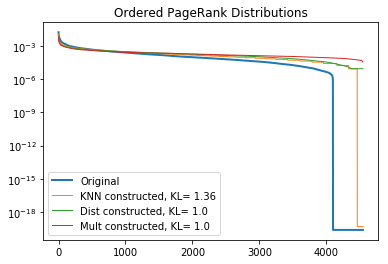

In [31]:
plt.figure(figsize=(6,4))
plt.semilogy(sorted(reduced_sites['PR_original'].values,reverse=True),label='Original', linewidth=2)
plt.semilogy(sorted(reduced_sites['PR_knn'].values,reverse=True),\
             label='KNN constructed, KL= ' + str(round(KL_knn,2)), linewidth=1)
plt.semilogy(sorted(reduced_sites['PR_dist'].values,reverse=True),\
             label='Dist constructed, KL= ' + str(round(KL_dist)), linewidth=1)
plt.semilogy(sorted(reduced_sites['PR_mult'].values,reverse=True),\
             label='Mult constructed, KL= ' + str(round(KL_mult)), linewidth=1)
plt.legend()
plt.title('Ordered PageRank Distributions')
plt.savefig(RES_FOLDER + 'pagerank.png', dpi=300)

We see that the distance constructed graph fits the best in terms of Pagerank probability distribution and KL-divergence

In [32]:
d = {'original': reduced_sites.sort_values('PR_original', ascending=False).take(range(10)).index.values,\
    'knn': reduced_sites.sort_values('PR_knn', ascending=False).take(range(10)).index.values,\
    'dist': reduced_sites.sort_values('PR_dist', ascending=False).take(range(10)).index.values,\
    'mult': reduced_sites.sort_values('PR_mult', ascending=False).take(range(10)).index.values}
imp_art = pd.DataFrame(data=d)
imp_art

,original,knn,dist,mult
0,United_States,United_States,United_States,United_States
1,United_Kingdom,Modern_history,Modern_history,Modern_history
2,Scientific_classification,United_Kingdom,Bird,Bird
3,Europe,England,United_Kingdom,United_Kingdom
4,England,20th_century,New_York_City,New_York_City
5,France,Europe,England,England
6,Animal,History_of_science,Fauna_of_Australia,Mexico_City
7,World_War_II,Middle_Ages,Mexico_City,Fauna_of_Australia
8,English_language,21st_century,Middle_Ages,Middle_Ages
9,London,History_of_the_world,History_of_science,Europe


The 10 most important articles (according to PageRank) are actually quite similar in our created networks. We see that in the original network, there are very general terms chosen as important (that the agent will visit often). This is still present in our constructed networks (with some exceptions). From this, we again have the impression that the knn and distance constructed networks fit best.

## Network Comparison using standard Metrics
We will now compare the networks using simple descriptive statistics like average degrees and number of edges.

In [33]:
def network_info(adj_mat):
    '''
    Get standard statistics for the network:
    adj_mat: network adjacency matrix
    outputs a dictionary of statistics
    '''
    n_nodes = adj_mat.shape[0]
    n_edges = int(adj_mat.sum())
    k_out = adj_mat.sum(axis=1)
    k_in = adj_mat.sum(axis=0)
    
    out_dict = {
        'n_nodes': n_nodes,
        'n_edges': n_edges,
        'k_out_avg': k_out.mean(),
        'k_in_avg': k_in.mean(),
    }
    return out_dict    

In [34]:
print('Original:\t' + str(network_info(dir_adj)))
print('KNN:\t\t' + str(network_info(knn_adj)))
print('Distance:\t' + str(network_info(dist_adj)))
print('Multiplication:\t' + str(network_info(mult_adj)))

Original:	{'n_nodes': 4549, 'n_edges': 118809, 'k_out_avg': 26.117608265552867, 'k_in_avg': 26.117608265552867}
KNN:		{'n_nodes': 4549, 'n_edges': 118274, 'k_out_avg': 26.0, 'k_in_avg': 26.0}
Distance:	{'n_nodes': 4549, 'n_edges': 118192, 'k_out_avg': 25.981974060233018, 'k_in_avg': 25.981974060233018}
Multiplication:	{'n_nodes': 4549, 'n_edges': 122825, 'k_out_avg': 27.00043965706749, 'k_in_avg': 27.00043965706749}


The General descriptive statistics point to the KNN model being the one that fits best.
We will now compare the degree distributions:

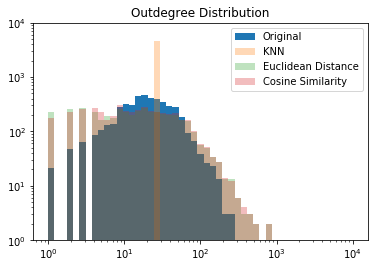

In [35]:
max_val=10000
plt.figure(figsize=(6,4))
logbins = np.logspace(0, math.log10(max_val), num=50)
plt.hist(dir_adj.sum(axis=1), log=True, bins=logbins, label='Original')
plt.hist(knn_adj.sum(axis=1), log=True, bins=logbins, label='KNN',alpha=0.3)
plt.hist(dist_adj.sum(axis=1), log=True, bins=logbins, label='Euclidean Distance',alpha=0.3)
plt.hist(mult_adj.sum(axis=1), log=True, bins=logbins, label='Cosine Similarity',alpha=0.3)
plt.xscale("log")
plt.legend()
plt.ylim((1, 1e4))
plt.title('Outdegree Distribution')
plt.savefig(RES_FOLDER + 'outdeg.png', dpi=300)

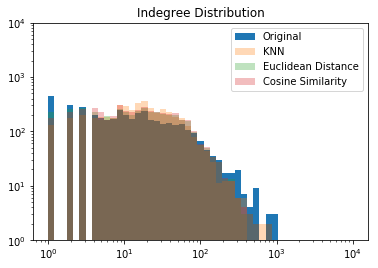

In [36]:
max_val=10000
plt.figure(figsize=(6,4))

logbins = np.logspace(0, math.log10(max_val), num=50)
plt.hist(np.transpose(dir_adj.sum(axis=0)), log=True, bins=logbins, label='Original')
plt.hist(np.transpose(knn_adj.sum(axis=0)), log=True, bins=logbins, label='KNN',alpha=0.3)
plt.hist(np.transpose(dist_adj.sum(axis=0)), log=True, bins=logbins, label='Euclidean Distance',alpha=0.3)
plt.hist(np.transpose(mult_adj.sum(axis=0)), log=True, bins=logbins, label='Cosine Similarity',alpha=0.3)
plt.xscale("log")
plt.title('Indegree Distribution')
plt.legend()
plt.ylim((1, 1e4))
plt.savefig(RES_FOLDER + 'indeg.png', dpi=300)

The plot of the degree distribution reveals a problem with KNN:
Since we take the *K-Nearest-Neighbors*, the degree of each node is K.

## Comparison using number of correct edges
We will now compare the number of edges that we predicted right:

In [37]:
def edge_prediction_stats(true_adj, pred_adj):
    '''
    Calculate the statistics for the predicted edges:
    true_adj: the true adjacency matrix
    pred_adj: the predicted adjacency matrix
    returns a dictionary with the following fields:
    ne_true: True number of edges
    ne_pred: predicted number of edges
    ne_fp: number of edges predicted where there is none
    ne_fn: number of missed edges
    ne_tp: number of correctly predicted edges
    '''
    ne_true = true_adj.sum()
    ne_pred = pred_adj.sum()
    ne_fp = (true_adj < pred_adj).astype(int).sum() #predicted an edge where there is none
    ne_fn = (true_adj > pred_adj).astype(int).sum() #did not predict an edge where there is one
    ne_tp = np.logical_and((true_adj == pred_adj), (true_adj == 1)).astype(int).sum() #correctly predict an edge
    edge_stats = {
        'ne_true': int(ne_true),
        'ne_pred': int(ne_pred),
        'ne_fp': ne_fp,
        'ne_fn': ne_fn,
        'ne_tp': ne_tp
    }
    return edge_stats

In [38]:
def ep_print(true_adj, pred_adj):
    eps = edge_prediction_stats(true_adj, pred_adj)
    print('In the True Network, there are {} edges. Our Algorithm predicted {} edges.\
    There were {} correct edge predictions. {} edges were predicted that are not actually present and \
    {} edges were missed.'.format(eps['ne_true'], eps['ne_pred'], eps['ne_tp'], eps['ne_fp'], eps['ne_fn']))

In [39]:
print('KNN')
ep_print(dir_adj, knn_adj)
print('Distance')
ep_print(dir_adj, dist_adj)
print('Multiplication')
ep_print(dir_adj, mult_adj)

KNN
In the True Network, there are 118809 edges. Our Algorithm predicted 118274 edges.    There were 28296 correct edge predictions. 89978 edges were predicted that are not actually present and     90513 edges were missed.
Distance
In the True Network, there are 118809 edges. Our Algorithm predicted 118192 edges.    There were 27892 correct edge predictions. 90300 edges were predicted that are not actually present and     90917 edges were missed.
Multiplication
In the True Network, there are 118809 edges. Our Algorithm predicted 122825 edges.    There were 28052 correct edge predictions. 94773 edges were predicted that are not actually present and     90757 edges were missed.


In [40]:
eps_knn = edge_prediction_stats(dir_adj, knn_adj)
eps_dist = edge_prediction_stats(dir_adj, dist_adj)
eps_mult = edge_prediction_stats(dir_adj, mult_adj)
d = {
    'method': ['KNN', 'Distance', 'Multiplication'],
    'precision': [eps_knn['ne_tp']/eps_knn['ne_pred'], eps_dist['ne_tp']/eps_dist['ne_pred'], \
                  eps_mult['ne_tp']/eps_mult['ne_pred']],
    'recall': [eps_knn['ne_tp']/eps_knn['ne_true'], eps_dist['ne_tp']/eps_dist['ne_true'], \
                  eps_mult['ne_tp']/eps_mult['ne_true']]
}
performance = pd.DataFrame(data=d)
performance

,method,precision,recall
0,KNN,0.239241,0.238164
1,Distance,0.235989,0.234763
2,Multiplication,0.228390,0.236110


These results suggest that the predicted edges were actually not very accurate. This is probably because there are many cross references to other topics, whereas our algorithms based on text features are predicting links based on similar text content, therefore not creating cross references across disciplines.
KNN seems to be the best in terms of precision. The Distance constructed graph outperforms KNN in terms of recall, but this is not surprising as it predicts twice as many edges as there actually are.

## Link Prediction
We have now seen different ways to try to recreate the Wikipedia network based on text data. We will now use the kNN network to obtain suggested links. This is done as follows: We identify the edges that are present in the kNN network but not in the original network. Then we compute the distances of these edges. We retain the largest edges such that on average 5 edges are suggested per node.

In [41]:
def edge_suggester(orig_adj, new_adj, tf_idf, n_suggestions=5000):
    """
    Takes as input original adjacency matrix and new adjacency matrix. Identifies edges
    which are "new" in the new network. Then computes the pairwise distances of the articles 
    using the tf_idf matrix, and takes the n_suggestions closest edges.
    """
    relevant_edges = np.logical_and(np.logical_not(orig_adj.astype(bool)), 
                                    new_adj.astype(bool))
    pw_dist = pairwise_distances(tf_idf)
    
    distance_vals = pw_dist[relevant_edges==True].flatten()


    assert distance_vals.size > n_suggestions, "n_suggestions was chosen too large."
    
    # Assert proper shape of distance_vals
    shape = distance_vals.shape
    if shape[0]==1:
        distance_vals = distance_vals.T
    if len(shape)>1:
        distance_vals = np.array(distance_vals)[:,0]
    
    # Find cutoff to have n_suggestions amount of edges in graph
    cutoff = np.partition(distance_vals, n_suggestions)[n_suggestions]
    if (cutoff==0):
        print('Warning: Cutoff is chosen to be zero, resulting in fully connected network.')

    # Return edges above cutoff
    out = binarize_with_cutoff(pw_dist, cutoff)
    return np.logical_and(out, np.logical_not(orig_adj))


In [42]:
suggestions = edge_suggester(dir_adj, knn_adj.toarray(), tf_idf_wiki, n_nodes*3)

In [43]:
sum(sum(np.logical_and(suggestions, dir_adj)))

0

#### Show randomly selected suggestions

In [44]:
sugg_ix = np.argwhere(suggestions)
n_show = 20
show_ix = np.random.randint(0, len(sugg_ix), n_show)
pd.DataFrame({'From':reduced_sites.iloc[sugg_ix[show_ix, 0]].index,
              'To': reduced_sites.iloc[sugg_ix[show_ix, 1]].index})

,From,To
0,Indian_Ocean,Geography_of_Africa
1,United_States,Economy_of_India
2,Tropical_Storm_Delta_%282005%29,Tropical_Storm_Isabel_%281985%29
3,Battle_of_Warsaw_%281920%29,Shoe_polish
4,Astronomy,Binary_star
5,Music_of_the_United_States,Popular_culture
6,Hurricane_Epsilon_%282005%29,Tropical_Storm_Bonnie_%282004%29
7,Animal_law,International_law
8,Tropical_Storm_Matthew_%282004%29,Hurricane_Edouard_%281996%29
9,Soil_salination,Soil_science
